In [2]:
import os, os.path as osp
import matplotlib.pyplot as plt

In [4]:
im_path = 'data_raw/'
im_path_out = 'data_ready/'
os.makedirs(im_path_out, exist_ok=True)

In [5]:
im_list = os.listdir(im_path)
im_list = [osp.join(im_path, n) for n in im_list if n.endswith('.JPG')]

In [6]:
im_list[0], len(im_list)

('data_raw/TRAIN013526.JPG', 17394)

In [7]:
for n in im_list:
    n_out = n.replace(im_path, im_path_out)
    print(n_out)
    break

data_ready/TRAIN013526.JPG


In [8]:
from torchvision import transforms as tr
import numpy as np
from PIL import Image
from tqdm import tqdm

from skimage.measure import regionprops, label
from skimage import io
from skimage.filters import threshold_li, threshold_otsu
from skimage import img_as_float, img_as_ubyte
from scipy.ndimage import binary_fill_holes

In [9]:
def getLargestCC(segmentation):
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segmentation.flat))
    return largestCC

In [10]:
from skimage.exposure import adjust_gamma
from skimage.color import rgb2hsv

In [64]:
def get_fov(binary):
    binary = getLargestCC(binary)
    regions = regionprops(binary.astype(np.uint8))
    areas = [r.area for r in regions]
    largest_cc_idx = np.argmax(areas)
    fov = regions[largest_cc_idx]
    
    return fov

def crop_resize_im(im, tg_size=(512, 512), allowed_eccentricity = 0.5):
    im = np.array(im)
    rsz = tr.Resize(tg_size)
    center_crop = tr.CenterCrop(tg_size)
    
    sat = rgb2hsv(im)[:, :, 1]
    t = threshold_li(sat)
    binary = sat > t
    fov = get_fov(binary)
    status='success'
    if fov.eccentricity > allowed_eccentricity:
        t = threshold_li(adjust_gamma(sat, 0.5))
        binary = adjust_gamma(sat, 0.5) > t
        fov = get_fov(binary)

    if fov.eccentricity > allowed_eccentricity:
        status = 'failed'
    
    cropped = im[fov.bbox[0]:fov.bbox[2], fov.bbox[1]: fov.bbox[3], :]
    cropped = Image.fromarray(cropped)
    
    return rsz(cropped), status

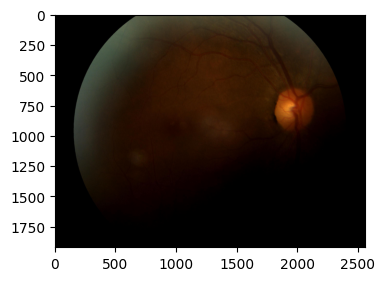

In [65]:
im = Image.open('data_raw/TRAIN005518.JPG')
plt.figure(figsize=(4,4))
plt.imshow(im)

In [66]:
im_out, status = crop_resize_im(im)
status

0.7208144256079736
success 0.7208970729680507


'failed'

In [62]:
im_out, status = crop_resize_im(im)
status

0.7208144256079736
success 0.7596990243468339


'failed'

In [ ]:
with open('log.txt', 'w') as f:
    print('Failed after exposure correction at {}'.format(n), file=f)

    
print('Exception at {}'.format(n))